# Problem Set 3

This is the third, and also the last, homework assignment, which accounts for $15\%$ of your final grade. There are three questions, and their weights are:
* Q1: $30\%$,
* Q2: $30\%$,
* Q3: $40\%$.

You may work with other students. The maximal number of students per group is two. However, you can work on your own. Be sure to indicate with whom you have worked in your submission.

### Deadline: Nov 27, 2024 (5 PM HK Time). 

There is a penalty for late submissions: $5\%$ will be subtracted from the total mark for every additional day after the deadline. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(8, 4))
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 15
np.set_printoptions(precision=4, suppress=True)
from dateutil.parser import parse
import statsmodels.api as sm
import statsmodels.formula.api as smf

---

You need to download the dataset used in this problem set: https://www.dropbox.com/scl/fi/irqn0aiwqen8a3nolq6h4/GlobalFactors_USA_ps3.parquet?rlkey=kqdrpudae94ufpslo9rluso0t&st=vu0zpieu&dl=0.

---

## Q1. Predicting Stock Returns

In this question, we focus on the cross-sectional predictability. We will run the OLS regressions to estimate the following models: <br>
$$
R_{i,t+1} = c + X^\top_{it} \beta + \epsilon_{i,t+1}, 
$$
* $R_{i,t+1}$: return of stock $i$ at time $t+1$
* $X_{it}$: the $K \times 1$ vector of signals of stock $i$ at time $t$ (i.e., we are living at time $t$ and observe $X_{it}$. We aim to predict the next-period $R_{i,t+1}$)
* The key parameter is $\beta$ : if $\beta_k$ ($1 \leq k \leq K$) is significantly different from zero, we can say that the $k$-th signal can predict stock returns. 

### Q1.1 ($10\%$)

You need to load the panel data of US stocks (```GlobalFactors_USA_ps3.parquet```) and preprocess the data. The variables can be grouped into three categories as follows:
```python
identifier_var_list = ["id", "eom", "size_grp", "ret_exc_lead1m", "me"]

st_reversal_list = ['iskew_capm_21d', 'iskew_ff3_21d', 'iskew_hxz4_21d', 'ret_1_0', 'rmax5_rvol_21d', 'rskew_21d']

accruals_list = ['cowc_gr1a', 'oaccruals_at', 'oaccruals_ni', 'seas_16_20na', 'taccruals_at', 'taccruals_ni']
```

First, you need remove the firms that do not have enough historic observations available (remove those with less than 24 months observations). 

Second, if a firm's market capitalization is less than 0.001% of the total market capitalization of the whole US stock market **per period**, we will exclude this firm from our analysis **in this period**. 

#### Answer:

In [2]:
identifier_var_list = ["id", "eom", "size_grp", "ret_exc_lead1m", "me"]

st_reversal_list = ['iskew_capm_21d', 'iskew_ff3_21d', 'iskew_hxz4_21d', 
                    'ret_1_0', 'rmax5_rvol_21d', 'rskew_21d']

accruals_list = ['cowc_gr1a', 'oaccruals_at', 'oaccruals_ni', 
                 'seas_16_20na', 'taccruals_at', 'taccruals_ni']

In [3]:
D = pd.read_parquet(
    "GlobalFactors_USA_ps3.parquet", 
    engine='pyarrow'
)
D = D.set_index(['id', 'eom'])  # create a hierarchical index using two columns 'id' and 'eom' as the index. 
print(D.shape)

(2917805, 15)


In [4]:
history_lengths = D.index.to_frame()['id'].groupby(
    level=0
).count()
cs_idx_with_history = history_lengths[
    history_lengths >= 24
].index 
ts_idx = D.index.get_level_values(1).unique()
df_idx = pd.MultiIndex.from_product(
    (ts_idx, cs_idx_with_history)
).to_frame()[[]]

# left merge to produce a balanced panel
D_full = pd.merge(
    D, 
    df_idx, 
    how='inner', 
    left_index=True, 
    right_index=True
)

In [6]:
total_market_cap = D_full['me'].groupby(level=1).sum()
market_cap_filter = (
    D_full['me'] 
    / total_market_cap
) > 0.00001
D_full = D_full[market_cap_filter]

In [7]:
D_full

size_grp  ret_exc_lead1m          me  iskew_capm_21d  \
id      eom                                                               
16424.0 1980-01-31     mega       -0.162615  769.360500        0.362228   
        1980-02-29    large       -0.075593  652.447875       -0.546837   
        1980-03-31    large        0.113308  610.962750       -0.031283   
        1980-04-30    large        0.064743  675.076125        0.741628   
        1980-05-31    large        0.014521  724.104000       -0.085251   
...                     ...             ...         ...             ...   
90963.0 2014-11-30    small        0.042931  784.730844        0.475269   
        2014-12-31    small       -0.039201  800.519292        0.384883   
        2015-01-31    small        0.020660  769.148614       -0.294452   
        2015-02-28    small        0.117004  785.936817       -0.610783   
        2015-03-31    small       -0.022948  877.778750       -0.010103   

                    iskew_ff3_21d  iskew_hxz4_21d   ret_1_0  rmax5_rvol_21d  \
id      eom                                                                   
16424.0 1980-01-31       0.407327        0.475523 -0.016872        1.380420   
        1980-02-29      -0.642052       -0.928328 -0.151961        1.104401   
        1980-03-31       0.106497        0.612202 -0.063584        1.355895   
        1980-04-30      -0.180984       -0.180364  0.126173        2.467519   
        1980-05-31      -0.326792       -0.416056  0.072626        1.620748   
...                           ...             ...       ...             ...   
90963.0 2014-11-30       0.225973        0.350202 -0.000240        0.931056   
        2014-12-31       0.212480        0.198355  0.042936        1.307759   
        2015-01-31       0.719219        0.015842 -0.039188        1.493195   
        2015-02-28      -0.242626        0.640467  0.020639        1.289475   
        2015-03-31       0.017877        0.055570  0.116996        1.393166   

                    rskew_21d  cowc_gr1a  oaccruals_at  oaccruals_ni  \
id      eom                                                            
16424.0 1980-01-31   0.266194   0.034485      0.065939      0.838825   
        1980-02-29  -0.367867   0.034485      0.065939      0.838825   
        1980-03-31   0.251088   0.034485      0.065939      0.838825   
        1980-04-30   0.087727   0.025277      0.092873      1.282676   
        1980-05-31   0.024339   0.025277      0.092873      1.282676   
...                       ...        ...           ...           ...   
90963.0 2014-11-30   0.207920   0.007081     -0.062228     -1.775345   
        2014-12-31  -0.208262   0.007081     -0.062228     -1.775345   
        2015-01-31   0.100646   0.017835     -0.053753     -1.454096   
        2015-02-28  -0.553157   0.017835     -0.053753     -1.454096   
        2015-03-31   0.175959   0.017835     -0.053753     -1.454096   

                    seas_16_20na  taccruals_at  taccruals_ni  
id      eom                                                   
16424.0 1980-01-31      0.007731      0.057258      0.728398  
        1980-02-29      0.013052      0.057258      0.728398  
        1980-03-31      0.014585      0.057258      0.728398  
        1980-04-30      0.013118      0.042374      0.585230  
        1980-05-31      0.014105      0.042374      0.585230  
...                          ...           ...           ...  
90963.0 2014-11-30           NaN     -0.065188     -1.859781  
        2014-12-31           NaN     -0.065188     -1.859781  
        2015-01-31           NaN     -0.008524     -0.230588  
        2015-02-28           NaN     -0.008524     -0.230588  
        2015-03-31           NaN     -0.008524     -0.230588  

[1643779 rows x 15 columns]

### Q1.2 ($10\%$)

Based on the preprocessed data in Q1.1, you now need to conduct the rank-transformation of firm characteristics, as what we did in the lecture note. 

You need to rank and center each characteristic cross-sectionally to lie within the $[-0.5, 0.5]$ range.
  * In each month, you rank the stocks by their firm characteristic $k$ and divide their ranks by the number of stocks during this period. Finally, you need to substract it by 0.5. Hence, the rank-transformed firm characteristic $k$ is
  $$
  X_{ikt} = \frac{\text{rank}_{ikt}}{N_t} - 0.5
  $$
    * $\text{rank}_{ikt} \in [1, N_t]$: the rank of stock $i$ by the values of firm characteristic $k$
    * $N_t$: the number of stocks in period $t$ <br>
    

Next, you need to handle missing data.
* Remove the firm-month observations whenever the return is missing. 
* Remove the firm characteristics whose missing rates are higher than $50\%$ in any month. <br>
* For the remaining sample, you are required to fill in missing data with zeros. 

#### Answer:

In [7]:
D_ranked = D_full[
    st_reversal_list + accruals_list
].groupby(level=1).rank(ascending=True)
D_ranked = (D_ranked 
            / D_ranked.groupby(level=1).max() 
            - 0.5)

In [8]:
D_ranked = D_ranked[D_full['ret_exc_lead1m'].isna() == False]
mis_rate = D_ranked.isna().groupby(level=1).mean()
D_ranked = D_ranked.loc[:,(mis_rate > 0.5).any()==False]
D_ranked = D_ranked.fillna(0)

In [9]:
D_ranked.columns

Index(['iskew_capm_21d', 'iskew_ff3_21d', 'iskew_hxz4_21d', 'ret_1_0',
       'rmax5_rvol_21d', 'rskew_21d', 'cowc_gr1a', 'oaccruals_at',
       'oaccruals_ni', 'taccruals_at', 'taccruals_ni'],
      dtype='object')

In [10]:
D_ranked

iskew_capm_21d  iskew_ff3_21d  iskew_hxz4_21d   ret_1_0  \
id      eom                                                                   
16424.0 1980-01-31       -0.034853       0.024129        0.080876 -0.298959   
        1980-02-29       -0.370885      -0.398675       -0.448268 -0.436995   
        1980-03-31        0.097777       0.082544        0.337382  0.330632   
        1980-04-30        0.211172      -0.245686       -0.234332  0.256291   
        1980-05-31       -0.292958      -0.357746       -0.375117  0.023214   
...                            ...            ...             ...       ...   
90963.0 2014-11-30        0.206823       0.074627        0.163113 -0.074476   
        2014-12-31        0.163394       0.071529        0.058906  0.147532   
        2015-01-31       -0.181947       0.295665       -0.055792  0.008156   
        2015-02-28       -0.324574      -0.204190        0.248935 -0.234491   
        2015-03-31       -0.065110      -0.053432       -0.025478  0.416343   

                    rmax5_rvol_21d  rskew_21d  cowc_gr1a  oaccruals_at  \
id      eom                                                              
16424.0 1980-01-31       -0.152022  -0.051832   0.038429     -0.106342   
        1980-02-29        0.016349  -0.305045   0.038234     -0.107868   
        1980-03-31        0.024217   0.116303   0.036965     -0.110390   
        1980-04-30        0.459861  -0.176658  -0.026975      0.034341   
        1980-05-31        0.237475  -0.230986  -0.018884      0.039089   
...                            ...        ...        ...           ...   
90963.0 2014-11-30       -0.087739   0.110519   0.057216     -0.157315   
        2014-12-31       -0.037879  -0.176367   0.057415     -0.161059   
        2015-01-31        0.196318  -0.033760   0.209206     -0.102063   
        2015-02-28        0.003101  -0.335227   0.210174     -0.099644   
        2015-03-31        0.211135   0.060863   0.208941     -0.101987   

                    oaccruals_ni  taccruals_at  taccruals_ni  
id      eom                                                   
16424.0 1980-01-31     -0.110994      0.038689     -0.036575  
        1980-02-29     -0.115059      0.040609     -0.029188  
        1980-03-31     -0.119481      0.036364     -0.032035  
        1980-04-30      0.038229     -0.088337     -0.145788  
        1980-05-31      0.044244     -0.088058     -0.146907  
...                          ...           ...           ...  
90963.0 2014-11-30     -0.247514     -0.068879     -0.149893  
        2014-12-31     -0.250088     -0.072737     -0.151638  
        2015-01-31     -0.211238      0.223731      0.198356  
        2015-02-28     -0.209609      0.226135      0.199321  
        2015-03-31     -0.211955      0.226301      0.203493  

[1640027 rows x 11 columns]

### Q1.3 ($10\%$)

Let's divide the full sample into two subsamples: 
* In-sample data: Jan 1980 - Dec 2004
* Out-of-sample data: Jan 2005 - End  <br>
<br>
* To assess predictive performance for individual excess stock return forecasts, we rely on the out-of-sample $R^2$ as <br>
<br>
$$
R^2_{oos} = 1 - \frac{\sum_{i,t \in \text{oos}} (R_{i,t+1} - \hat{R}_{i,t+1})^2}{\sum_{i,t \in \text{oos}} R^2_{i,t+1}}. 
$$
<br>
* $\sum_{i,t \in \text{oos}}$ indicates that fits are only assessed on the OOS subsample, whose data never enter into model estimation or tuning.

You are required to do the following analysis:
- Use the signals in ```st_reversal_list``` and ```accruals_list``` (that were not eliminated in Q1.2) to predict individual stock returns (```ret_exc_lead1m```). 
   * Interpret the OLS estimates: Which variables have signfinicant predictive power?
   * Evaluate the out-of-sample performance of these signals. 

#### Answer:

In [11]:
D_ranked_in = D_ranked[(D_ranked.index.get_level_values(1) 
                        < '2005-01')]
D_ranked_oos = D_ranked[(D_ranked.index.get_level_values(1) 
                         >= '2005-01')]

In [12]:
data_in = pd.merge(
    D_full[['ret_exc_lead1m']], 
    D_ranked_in, 
    how='inner', 
    left_index=True, 
    right_index=True
)
data_oos = pd.merge(
    D_full[['ret_exc_lead1m']],
    D_ranked_oos, 
    how='inner', 
    left_index=True, 
    right_index=True
)

In [13]:
model = sm.OLS(
    data_in[['ret_exc_lead1m']].values, 
    sm.add_constant(
        data_in[[x for x in (
            st_reversal_list + accruals_list
        ) if x in data_in.columns]]
    )
)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     105.8
Date:                Sat, 07 Dec 2024   Prob (F-statistic):          1.30e-242
Time:                        17:19:11   Log-Likelihood:             5.6457e+05
No. Observations:             1058173   AIC:                        -1.129e+06
Df Residuals:                 1058161   BIC:                        -1.129e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0063      0.000     45.

In [14]:
y_oos = data_oos[['ret_exc_lead1m']].values
X_oos = data_oos[[x for x in st_reversal_list + accruals_list 
                  if x in data_in.columns]].values

In [15]:
def get_R2(beta_hat, y, X):
    """
    beta_hat: a pandas.Series of coefficient estimates
    y: an ndarray of dependent variables
    X: a two-dimensional ndarray of independent variables
    This function returns the R-squared in the linear models
    """
    pred_err = y.reshape((len(y),)) - sm.add_constant(X) @ beta_hat
    return (1 - 
            ((y.reshape(len(y),) 
              - sm.add_constant(X) @ beta_hat)**2).sum() 
            / (y**2).sum())

In [16]:
get_R2(
    results.params, 
    y_oos, 
    sm.add_constant(X_oos)
)

0.002471969258770912

---

## Q2. Quintile Portfolios Sorted by the Accruals Signal

In this question, you will be guided to construct the cross-section of five portfolios sorted by the accruals signal. The accruals signal was initially proposed by Sloan (1996). Accordingly, the accrual component of corporate earnings is computed using the information from the balance sheet and income statement:
$$
\text{Accruals} = (\Delta \text{CA} - \Delta \text{Cash}) - (\Delta \text{CL} - \Delta \text{STD} - \Delta \text{TP}) - \text{Dep}, 
$$
where 
* $\Delta \text{CA}$ is the change in the current asset,
* $\Delta \text{Cash}$ is the change in cash equivalents,
* $\Delta \text{CL}$ is the change in current liabilities,
* $\Delta \text{STD}$ is the change in debt included in current liabilities,
* $\Delta \text{TP}$ is the change in income taxes payable, and
* $\text{Dep}$ is the depreciation and amortization expense. 

Briefly speaking, the accrual component of corporate earnings is more likely to be subject to earnings management by corporate managers than the cash flow component. In other words, accruals probably represent the *"spurious"* components in the corporate earnings. Empirically, Sloan (1996) finds that firms with higher (lower) accruals in the past tend to underperform (outperform) in the future. In this question, we focus on the most common accruals signal ```'oaccruals_at'```. 

You need to follow the same step as in Q1.1 and Q1.2 to preprocess the data. After you finish, you will need to merge the ```D_full``` and ```D_ranked``` as follows:
```python
data_final = pd.merge(D_full[['ret_exc_lead1m', "me"]], D_ranked['oaccruals_at'], how='inner', 
                      left_index=True, right_index=True)
```
Next, you should keep the observations after 1990 by executing the following command:
```python
data_final = data_final[data_final.index.get_level_values(1) > '1989-12-31']
```

In [17]:
data_final = pd.merge(
    D_full[['ret_exc_lead1m', "me"]], 
    D_ranked['oaccruals_at'], 
    how='inner', 
    left_index=True, 
    right_index=True
)
data_final = data_final[data_final.index.get_level_values(1) > '1989-12-31']

In [18]:
data_final

ret_exc_lead1m           me  oaccruals_at
id      eom                                                  
16424.0 1990-01-31        0.071744  4366.204750      0.269320
        1990-02-28        0.057887  4704.857750      0.278427
        1990-03-31        0.003219  5007.226500      0.283984
        1990-04-30        0.089750  5031.416000      0.061591
        1990-05-31        0.035769  5515.206000      0.070543
...                            ...          ...           ...
90963.0 2014-11-30        0.042931   784.730844     -0.157315
        2014-12-31       -0.039201   800.519292     -0.161059
        2015-01-31        0.020660   769.148614     -0.102063
        2015-02-28        0.117004   785.936817     -0.099644
        2015-03-31       -0.022948   877.778750     -0.101987

[1215399 rows x 3 columns]

### Q2.1 ($10\%$)

For each month, sort the stocks into five groups based on their values of the accruals signal ```oaccruals_at```. You also need to assign the labels ```["Q1","Q2","Q3","Q4","Q5"]``` to the five groups (Hint: use ```groupby```, ```apply```, and ```pd.qcut``` methods). 

The output should be a ```pd.Series``` named ```oaccruals_at_cat```. Next, you will use ```oaccruals_at_cat``` to create a dummy matrix. Since ```oaccruals_at_cat``` has five distinct values, you would derive a matrix or DataFrame with five columns containing all 1s and 0s (the resultant dummy matrix is named ```oaccruals_at_dummy```).

In [18]:
data_final

ret_exc_lead1m           me  oaccruals_at
id      eom                                                  
16424.0 1990-01-31        0.071744  4366.204750      0.269320
        1990-02-28        0.057887  4704.857750      0.278427
        1990-03-31        0.003219  5007.226500      0.283984
        1990-04-30        0.089750  5031.416000      0.061591
        1990-05-31        0.035769  5515.206000      0.070543
...                            ...          ...           ...
90963.0 2014-11-30        0.042931   784.730844     -0.157315
        2014-12-31       -0.039201   800.519292     -0.161059
        2015-01-31        0.020660   769.148614     -0.102063
        2015-02-28        0.117004   785.936817     -0.099644
        2015-03-31       -0.022948   877.778750     -0.101987

[1215399 rows x 3 columns]

#### Answer:

In [19]:
oaccruals_at_cat = data_final['oaccruals_at'].groupby(level=1).apply(
    pd.qcut,
    5,
    labels=["Q1","Q2","Q3","Q4","Q5"]
)
oaccruals_at_dummy = pd.get_dummies(oaccruals_at_cat)

In [20]:
oaccruals_at_dummy.index.names = ['eom', 'id', 'eom2']
oaccruals_at_dummy = oaccruals_at_dummy.reset_index().drop(
    ['eom2'],
    axis=1
).set_index(['eom', 'id'])
oaccruals_at_dummy.head()

Q1     Q2     Q3     Q4     Q5
eom        id                                        
1990-01-31 16424.0  False  False  False  False   True
           16432.0  False  False  False   True  False
           16460.0  False  False  False  False   True
           16505.0  False  False   True  False  False
           16513.0  False  False   True  False  False

### Q2.2 ($10\%$)

In this question, you need to first merge ```D_full[['ret_exc_lead1m', 'me']]``` with ```oaccruals_at_dummy```. The resultant DataFrame is named as ```D_subset3```. Next, you group the stocks into five groups based on the dummy matrix and compute the average returns in five groups. That is to say, you will need to report the average returns for groups 'Q1' -- 'Q5'. Finally, you need to make a bar plot of average returns in five groups. Is the bar plot consistent with the accruals phenomenon as described at the beginning of this question? 

#### Answer:

In [21]:
D_subset3 = D_full[['ret_exc_lead1m', 'me']].join(oaccruals_at_dummy)
accruals_portfolios = pd.Series(np.zeros(5))

for i in range(5):
    accruals_portfolios.iloc[i] = D_subset3.loc[
        D_subset3['Q'+str(i+1)]==1, 
        'ret_exc_lead1m'
    ].mean()
    
accruals_portfolios.index = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']

<Axes: >

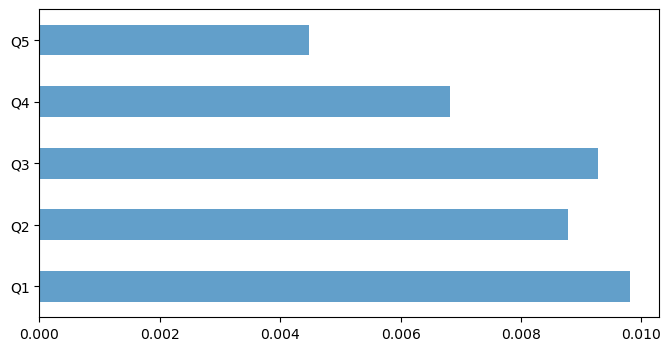

In [22]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 1)
accruals_portfolios.plot.barh(alpha=0.7)

### Q2.3 ($10\%$)

In Q2.2, you create the so-called equally weighted portfolios. In other words, the stocks in each group (Q1 -- Q5) have the same portfolio weights. However, the value-weighted portfolios are more common in reality. 

Suppose that we use $\text{ME}_{it}$ to denote the market capitalization of firm $i$ at time $t$. The value-weighted portfolio return in the group $j$ is <br>
<br>
$$
R^{vw}_{j,t+1} = \frac{\sum^{N_{jt}}_{i = 1} \text{ME}_{it} R_{i,t+1}}{\sum^{N_{jt}}_{i = 1} \text{ME}_{it}}, 
$$
where $N_{jt}$ is the number of firms in the $j$-th group at time $t$. 

In this question, you need to compute the value-weighted portfolio returns for the five groups of stocks sorted by the accruals signal. Finally, you need to make a bar plot of average returns in five groups, as in Q2.2. What are the differences in the five accruals portfolios between Q2.2 and Q2.3? 

In [23]:
D_subset3 

ret_exc_lead1m          me     Q1    Q2     Q3     Q4  \
id      eom                                                                 
16424.0 1980-01-31       -0.162615  769.360500    NaN   NaN    NaN    NaN   
        1980-02-29       -0.075593  652.447875    NaN   NaN    NaN    NaN   
        1980-03-31        0.113308  610.962750    NaN   NaN    NaN    NaN   
        1980-04-30        0.064743  675.076125    NaN   NaN    NaN    NaN   
        1980-05-31        0.014521  724.104000    NaN   NaN    NaN    NaN   
...                            ...         ...    ...   ...    ...    ...   
90963.0 2014-11-30        0.042931  784.730844  False  True  False  False   
        2014-12-31       -0.039201  800.519292  False  True  False  False   
        2015-01-31        0.020660  769.148614  False  True  False  False   
        2015-02-28        0.117004  785.936817  False  True  False  False   
        2015-03-31       -0.022948  877.778750  False  True  False  False   

                       Q5  
id      eom                
16424.0 1980-01-31    NaN  
        1980-02-29    NaN  
        1980-03-31    NaN  
        1980-04-30    NaN  
        1980-05-31    NaN  
...                   ...  
90963.0 2014-11-30  False  
        2014-12-31  False  
        2015-01-31  False  
        2015-02-28  False  
        2015-03-31  False  

[1643779 rows x 7 columns]

#### Answer:

In [24]:
def get_port_vw(g):
    return np.average(
        a=g.ret_exc_lead1m, 
        weights=g.me
    )

In [25]:
accruals_portfolios = pd.Series(np.zeros(5))

for i in range(5):
    accruals_portfolios.iloc[i] = D_subset3.loc[
        D_subset3['Q'+str(i+1)]==1,
        ["ret_exc_lead1m", "me"]
    ].groupby(level=1).apply(get_port_vw).mean()

accruals_portfolios.index = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']

accruals_portfolios

Q1    0.009094
Q2    0.008455
Q3    0.007857
Q4    0.006254
Q5    0.004782
dtype: float64

In [26]:
D_subset3.loc[D_subset3['Q'+str(1)]==1,
        ["ret_exc_lead1m", "me"]
    ].groupby(level=1).apply(get_port_vw)

eom
1990-01-31    0.024781
1990-02-28    0.010788
1990-03-31   -0.050142
1990-04-30    0.082757
1990-05-31   -0.024798
                ...   
2021-08-31   -0.027763
2021-09-30    0.082634
2021-10-31   -0.022942
2021-11-30    0.009573
2021-12-31   -0.076864
Length: 384, dtype: float64

<Axes: >

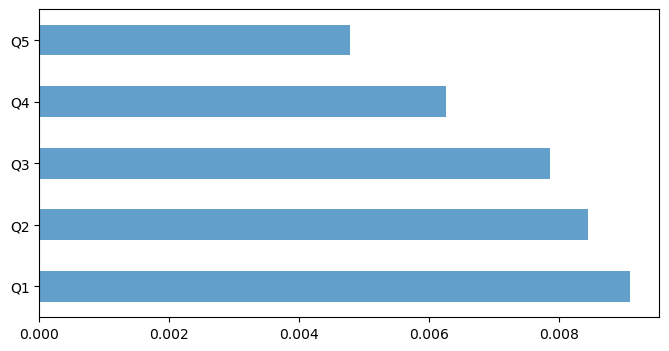

In [27]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 1)
accruals_portfolios.plot.barh(alpha=0.7)

---

## Q3. *"Alpha"* of Accruals Anomaly based on Fama-French Three Factor Models

During the lecture, we introduced how to use the ```statmodels``` package to test the Capital Asset Pricing Model (CAPM). In fact, the Fama-French three-factor model has been one of the most popular factor pricing models in the past 30 years. In this question, you will explore whether the three-factor model is able to explain the accruals anomaly that we consider in Q2. 

The baseline model is that the required return of an asset should be determined by the systematic risks (betas) as follows: 
$$
\mathbf{E} [ R_i ] - R_f = \beta^{mkt}_i \big( \mathbf{E} [ R_m ] - R_f \big) + \beta^{smb}_i \mathbf{E} [ R_{smb} ]  + \beta^{hml}_i \mathbf{E} [ R_{hml} ], 
$$
 * $\mathbf{E} [ R_i ]$: the expected/required return of the asset $i$
 * $R_f$: the risk-free rate
 * $\mathbf{E} [ R_m ]$: the expected/required return of the market portfolio ($m$ is the abbreviation for market)
 * $\mathbf{E} [ R_{smb} ]$: the expected/required return of the SMB portfolio
 * $\mathbf{E} [ R_{hml} ]$: the expected/required return of the HML portfolio
 * $\beta^{mkt}_i$, $\beta^{smb}_i$, and $\beta^{hml}_i$: the beta, or the sensitivity of the expected excess return to the expected excess market, SMB, and HML returns
 
Please note that SMB and HML portfolios are excess returns by construction, so you do not need to substract the risk-free rate from $R_{smb}$ and $R_{hml}$.

We estimate the above model via the simple OLS regression:   <br>
<br>
$$
R_{it} - R_{ft} = \alpha_i + \beta^{mkt}_i \big( R_{mt} - R_{ft} \big) + \beta^{smb}_i R_{smb,t} + \beta^{hml}_i R_{hml,t} + \epsilon_{it}, 
$$
* $R_{it}$, $R_{mt}$, $R_{smb,t}$, $R_{hml,t}$, and $R_{ft}$: the time-$t$ return of asset $i$, the market portfolio, the SMB portfolio, the HML portfolio, and the risk-free asset
* $\epsilon_{it}$: the random error term
* $\alpha_i$ is called the pricing errors (***alpha***)

### Q3.1 ($8\%$)

First, you need to load the Fama-French three factors in ```week10_test_assets.xlsx```:
- ```FF3_factors```: Fama-French three factors at the daily frequency (they are all daily excess returns)

Second, you need to compute the **monthly excess returns** of the Fama-French three factors, following what we did in the lecture 10. In other words, you need to use the ```resample``` method to transform the daily excess returns into monthly excess returns. 

#### Answer:

In [28]:
factors_daily = pd.read_excel(
    "week10_test_assets.xlsx", 
    sheet_name="FF3_factors", 
    index_col=0
)
factors_daily.index = [str(x) for x in factors_daily.index]
factors_daily.index = [parse(x) for x in factors_daily.index]

In [29]:
FF3_daily = factors_daily[['Mkt-RF', 'SMB', 'HML']] / 100
RF_daily = factors_daily[['RF']] / 100
FF3_gross_daily = pd.DataFrame(
    FF3_daily.values 
    + RF_daily.values @ np.ones((1,3)), 
    columns=["MKT", 'SMB_gross', 'HML_gross']
)
FF3_gross_daily.index = FF3_daily.index

FF3_gross_monthly = (1 + FF3_gross_daily).resample('ME').prod() - 1
RF_monthly = (1 + RF_daily).resample('ME').prod() - 1

FF3_monthly = pd.DataFrame(
    FF3_gross_monthly.values 
    - RF_monthly.values @ np.ones((1,3)), 
    index=FF3_gross_monthly.index, 
    columns=['MKT_RF', 'SMB', 'HML']
)

In [30]:
FF3_monthly

,MKT_RF,SMB,HML
1963-07-31,-0.004037,-0.004630,-0.009818
1963-08-31,0.050919,-0.009818,0.016729
1963-09-30,-0.015770,-0.002970,0.000064
1963-10-31,0.025173,-0.006278,0.000175
1963-11-30,-0.008503,-0.012640,0.018532
...,...,...,...
2023-02-28,-0.025902,0.011906,-0.010134
2023-03-31,0.024617,-0.053021,-0.087412
2023-04-30,0.006193,-0.032750,-0.001070
2023-05-31,0.003500,0.016764,-0.076295


### Q3.2 ($8\%$)

Second, you need to construct the accruals (value-weighted) anomaly based on your answer in Q2.3. After you obtain the value-weighted portfolio returns in groups Q1 and Q5 (denoted as ```port_ret_Q1``` and ```port_ret_Q5```), you long the Q1 portfolio and short the Q5 portfolio, as follows:
```python
port_ret_ls = port_ret_Q1 - port_ret_Q5
```
```port_ret_ls``` is the accruals anomaly. Since this is a long-short portfolio, it has zero cost and is naturally an excess return. 

Now, you need to answer the following questions:
* What is the annualized mean excess return of the accruals anomaly ```port_ret_ls```?
* Can you compute the average annualized returns of the accruals anomaly ```port_ret_ls``` using a rolling-window of 120 months? That is, in month $t$, you need to use the data between month $t-119$ and $t$ to compute the mean return. Finally, you need to make a time-series plot of the rolling-window estimates of the average returns. 

#### Answer:

In [31]:
def get_port_vw(g):
    return np.average(
        a=g.ret_exc_lead1m, 
        weights=g.me
    )

In [32]:
port_ret_Q1 = D_subset3.loc[
    D_subset3['Q1']==1,
    ["ret_exc_lead1m", "me"]
].groupby(level=1).apply(get_port_vw)

port_ret_Q5 = D_subset3.loc[
    D_subset3['Q5']==1,
    ["ret_exc_lead1m", "me"]
].groupby(level=1).apply(get_port_vw)

port_ret_ls = port_ret_Q1 - port_ret_Q5
print('Annualized mean excess return of the accruals anomaly:', 
      port_ret_ls.mean() * 12)

Annualized mean excess return of the accruals anomaly: 0.05173556345525274


<Axes: xlabel='eom'>

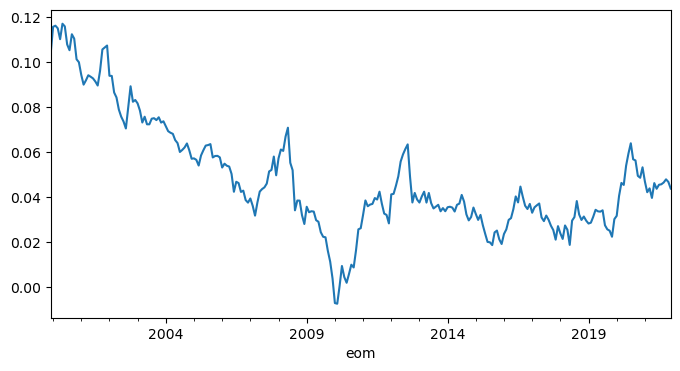

In [33]:
mean_ret_rolling = (12 * port_ret_ls).rolling(
    120, 
    min_periods=120
).mean()

mean_ret_rolling.dropna().plot()

### Q3.3 ($8\%$)

In this question, you are required to run the OLS regressions for the accrual anomaly portfolio. You need to regress ```port_ret_ls``` on the monthly Fama-French three factors obtained in Q3.1. 

You need to print the following results:
- ```alpha``` ($\alpha_i$ in the above equation);
- ```beta``` ($\beta_i^{mkt}$, $\beta_i^{smb}$, $\beta_i^{hml}$);
- The $95\%$ confidence intervals of ```alpha``` and ```beta```.

Can the Fama-French three factors explain the accruals anomaly?

#### Answer:

In [34]:
port_ret_ls_df = pd.merge(
    pd.DataFrame(port_ret_ls), 
    FF3_monthly, 
    how='inner',
    left_index=True, 
    right_index=True
)
port_ret_ls_df.columns = ['Accruals', 'MKT_RF', 'SMB', 'HML']

In [35]:
port_ret_ls_df.mean() * 12

Accruals    0.051736
MKT_RF      0.090025
SMB         0.010206
HML         0.015436
dtype: float64

In [36]:
model = sm.OLS(
    port_ret_ls_df.iloc[:,0:1].values, 
    sm.add_constant(
        port_ret_ls_df.iloc[:,1:4].values
    )
)
results = model.fit()
print(results.summary())

### Since the alpha (const) is significantly positive, the accruals anomaly cannot be explained by the Fama-French three factors.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     3.862
Date:                Sat, 07 Dec 2024   Prob (F-statistic):            0.00963
Time:                        15:30:20   Log-Likelihood:                 805.54
No. Observations:                 384   AIC:                            -1603.
Df Residuals:                     380   BIC:                            -1587.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0049      0.002      3.133      0.0

In [37]:
results.conf_int()[0,:]

array([0.0018, 0.0079])

In [38]:
#port_ret_ls_df.rolling(120).apply(reg_ff3)

### Q3.4 ($16\%$)

In this question, you need to obtain the rolling-window estimates of the alphas of the accruals anomaly in the Fama-French three-factor model. In particular, for each month $t$, you need to use the data between months $t-119$ and $t$ to estimate the OLS regression as in Q3.3. Next, you obtain the point estimate of $\alpha_{it}$ in each month $t$ using a rolling window of 120 months in the OLS regressions. 

Finally, you need to make a time-series plot of the estimates of alphas. According to the plot that you make, do you observe that the alphas increase or decline over time? Do you have any potential explanations for this phenomenon?

#### Answer:

In [39]:
def reg_ff3(data_df):
    model = sm.OLS(
        data_df.iloc[:,0:1].values, 
        sm.add_constant(data_df.iloc[:,1:4].values)
    )
    results = model.fit()
    return results.params[0]

In [40]:
alpha_seq = []
alpha_95CI_seq = []
rolling_window_len = 120

for data_df in port_ret_ls_df.rolling(rolling_window_len):
    #print(data_df.shape)
    #print(type(data_df))
    if data_df.shape[0] >= rolling_window_len:
        alpha_t = reg_ff3(data_df)
        alpha_seq.append(alpha_t)
    else:
        alpha_seq.append(np.nan) 

In [41]:
alpha_series = pd.Series(
    alpha_seq, 
    index=port_ret_ls_df.index
)
alpha_series

1990-01-31         NaN
1990-02-28         NaN
1990-03-31         NaN
1990-04-30         NaN
1990-05-31         NaN
                ...   
2021-08-31    0.003775
2021-09-30    0.004049
2021-10-31    0.004117
2021-11-30    0.003991
2021-12-31    0.003786
Length: 384, dtype: float64

<Axes: >

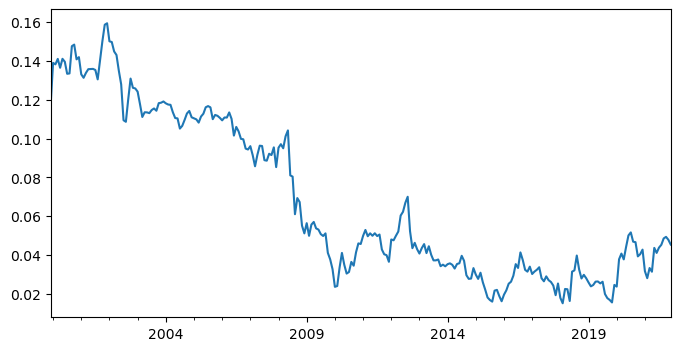

In [42]:
(12 * alpha_series).dropna().plot()

Over time, we observe that the alphas of the accrual anomaly tend to decline. For example, the annualized alpha was about $15\%$ in the late 1990s, but it decreased to only $2-4\%$ in the recent subsample. Some potential explanations:
* The anomaly was never there in the first place. It was discovered by p-hacking.
* The paper, Sloan (1996), was published in 1996. After the publication of this paper, investors started to learn that they could profit from trading the accruals signal. As more arbitrageurs engage in the same signal, the profitability of the accruals signal declines over time.

Students can get full marks only if they provide both two explanations. 

---

# END